# Get the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

from pandas.plotting import scatter_matrix
import math

In [2]:
import tensorflow as tf
#from tensorflow import keras
import keras
print(tf.__version__)
print(keras.__version__)

2024-04-12 17:20:15.312390: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-12 17:20:15.312797: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-12 17:20:15.315334: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-12 17:20:15.349601: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 17:20:16.029504: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

2.16.1
3.0.5


## Define global constants

In [3]:
MY_OPTIMIZER = "SGD"
MY_EPOCHS = 50
#MY_LEARNING_RATE = 0.1

# Get the Data

In [4]:
maneuvers = pd.read_csv("maneuvers.csv")
#maneuvers.head()
maneuvers.shape

(1030, 8)

In [5]:
maneuvers.describe()

,t,x,y,z,dx,dy,dz,dv_st
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1.030000e+03,1.030000e+03
mean,3779.433654,-0.990423,-0.000002,-0.000161,-0.000001,0.000001,7.629146e-07,1.496077e-07
std,2172.569576,0.001019,0.003207,0.000692,0.002136,0.006600,1.426902e-03,2.166866e-07
min,21.909760,-0.991664,-0.004520,-0.001118,-0.003245,-0.009031,-2.043062e-03,-2.219465e-07
25%,1900.671750,-0.991455,-0.003224,-0.000846,-0.001973,-0.006496,-1.434597e-03,-2.287116e-08
50%,3779.433500,-0.990581,-0.000023,-0.000212,-0.000007,-0.000397,9.653665e-06,8.666964e-08
75%,5658.195250,-0.989402,0.003220,0.000523,0.001975,0.006452,1.439907e-03,3.219879e-07
max,7536.958000,-0.988842,0.004520,0.000896,0.003245,0.009926,2.048094e-03,7.003602e-07


## Add/Drop Features

Try adding new attribute "angle" = angle in the periodic orbit, which is essentially time/period.

In [6]:
maneuvers["angle"]=maneuvers["t"].apply(lambda x: math.fmod(x, 0.3059226605957322E+01))
maneuvers = maneuvers.drop(["t", "dx", "dy", "dz"], axis=1)

# Prepare the Data for Machine Learning Algorithms

In [7]:
# Let's separate the predictors and the labels
maneuvers_predictors = maneuvers.drop("dv_st", axis=1)
maneuvers_labels = maneuvers[["dv_st"]].copy()
maneuvers_predictors.head()
#maneuvers_labels.head()

,x,y,z,angle
0,-0.988935,-0.001338,-0.001081,0.495174
1,-0.991622,-0.001865,0.000796,1.679971
2,-0.989867,0.003980,-0.000637,2.864777
3,-0.990210,-0.004343,-0.000449,0.990348
4,-0.991548,0.002750,0.000664,2.175144


## Create a Train/Test/Validation Set

In [8]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
maneuvers_predictors, maneuvers_labels, test_size=0.2, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(
X_train_full, y_train_full)
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)
X_train.head()

(618, 4)
(206, 4)
(206, 4)


,x,y,z,angle
105,-0.990906,0.004446,0.000008,2.530162
440,-0.991634,-0.001514,0.000815,1.738478
431,-0.988893,0.000994,-0.001076,0.253236
171,-0.990807,-0.004493,-0.000065,1.186959
129,-0.988846,-0.000240,-0.001113,0.373119


In [9]:
# Scale all the features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)
X_train_scaled[:5]

array([[0.26848373, 0.99178274, 0.56004822, 0.82821287],
       [0.01024314, 0.33241997, 0.96147282, 0.5688188 ],
       [0.98188842, 0.60985667, 0.02084051, 0.08218219],
       [0.30360814, 0.00283081, 0.5237591 , 0.3881146 ],
       [0.99868859, 0.4733434 , 0.00233109, 0.1214616 ]])

In [10]:
# Scale target variable dv_st as well.
# Rationale: dv_st takes very small values (10^{-8}), 
# so MSE may be tiny and not computed properly. Also, NN may converge faster?

scaler_target = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train)
y_valid_scaled = scaler.transform(y_valid)
y_test_scaled = scaler.transform(y_test)

# Building, Training, and Evaluating the Model

The output layer has a single neuron (since we only want to
predict a single value) and uses no activation function, and the loss function is the mean squared error. 

Since the dataset is quite noisy, we just use a single hidden layer with fewer neurons than before, to avoid overfitting.

In [11]:
model = keras.models.Sequential([
keras.layers.Dense(300, activation="relu", input_shape=X_train_scaled.shape[1:]),
keras.layers.Dense(100, activation="relu"),
keras.layers.Dense(1)
])
model.summary()

/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 300)            │         1,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,701 (123.83 KB)

 Trainable params: 31,701 (123.83 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(loss="mean_squared_error", optimizer=MY_OPTIMIZER)
history = model.fit(X_train_scaled, y_train_scaled, epochs=MY_EPOCHS, 
                    validation_data=(X_valid_scaled, y_valid_scaled))

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1564 - val_loss: 0.0558
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0510 - val_loss: 0.0404
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0356 - val_loss: 0.0351
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0320 - val_loss: 0.0315
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0283 - val_loss: 0.0289
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0281 - val_loss: 0.0269
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0254 - val_loss: 0.0254
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0247 - val_loss: 0.0243
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0248 - val_loss: 0.0234
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0228 - val_loss: 0.0226
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0210 - val_loss: 0.0220
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0211 - val_lo

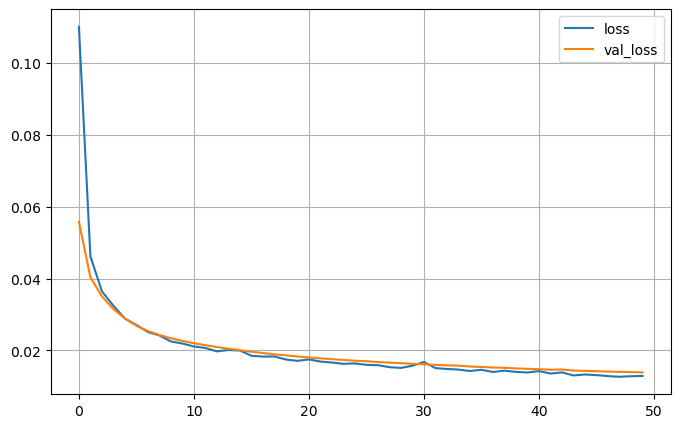

In [13]:
# Plot learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 5e-4) # set the vertical range to [0-1]
plt.show()

In [14]:
mse_test = model.evaluate(X_test_scaled, y_test_scaled)
np.sqrt(mse_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0119 


0.10989209538998432

In [15]:
X_new = X_test_scaled[:3] # pretend these are new instances
y_pred = model.predict(X_new)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [16]:
y_test_scaled[:3]

array([[0.30569269],
       [0.09994272],
       [0.1228273 ]])

In [17]:
y_pred[:3]

array([[0.25444192],
       [0.096791  ],
       [0.1648734 ]], dtype=float32)

# Fine-Tuning Neural Network Hyperparameters

Wrap our Keras models in objects that mimic regular Scikit-Learn regressors.

def build_model(n_hidden, n_neurons, learning_rate, 
                input_shape):
    model = keras.models.Sequential()
    options = {"input_shape": input_shape}
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu", 
                                     **options))
        options = {}
    model.add(keras.layers.Dense(1, **options))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

from scikeras.wrappers import KerasRegressor

keras_reg = KerasRegressor(build_model, n_hidden=1, n_neurons=30, learning_rate=3e-3, 
                input_shape=[8])

In [18]:
import keras
from keras import layers


def build_model(hp):
    model = keras.Sequential()
    #model.add(layers.Flatten())
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            layers.Dense(
               # Tune number of units separately for each layer.
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation="relu",
            )
        )
    model.add(layers.Dense(1))
    #learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        #optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
        optimizer=MY_OPTIMIZER,
        loss="mean_squared_error",
    )
    return model


In [19]:
# Quickly test if model builds successfuly
import keras_tuner

build_model(keras_tuner.HyperParameters())

<Sequential name=sequential_1, built=False>

Use a randomized search to train hundreds of hyperparameter combinations  and see which one performs best on the validation set.

Note that RandomizedSearchCV uses K-fold cross-validation, so it
does not use X_valid and y_valid_scaled . These are just used for early stopping.

from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, 
                                   n_iter=10, cv=3)
rnd_search_cv.fit(X_train, y_train_scaled, epochs=100,
                  validation_data=(X_valid, y_valid_scaled),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [20]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=20,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

In [21]:
# print a summary of the search space
tuner.search_space_summary()

Search space summary
Default search space size: 2
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}


Then, start the search for the best hyperparameter configuration. All the arguments passed to search is passed to model.fit() in each execution. Remember to pass validation_data to evaluate the model.

In [22]:
tuner.search(X_train_scaled, y_train_scaled, epochs=MY_EPOCHS, validation_data=(X_valid_scaled, y_valid_scaled))

Trial 4 Complete [00h 00m 08s]
val_loss: 0.011502386070787907

Best val_loss So Far: 0.011502386070787907
Total elapsed time: 00h 00m 31s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
5                 |3                 |num_layers
352               |288               |units_0
320               |128               |units_1
512               |192               |units_2
96                |288               |units_3

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1715 - val_loss: 0.0800
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0675 - val_loss: 0.0527
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0490 - val_loss: 0.0454
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0428 - val_loss: 0.0403
Epoch 5/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0423

KeyboardInterrupt: 

## Query the results
When search is over, you can retrieve the best model(s). The model is saved at its best performing epoch evaluated on the validation_data.

In [ ]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

In [ ]:
tuner.results_summary()

In [ ]:
mse_test = best_model.evaluate(X_test_scaled, y_test_scaled)
np.sqrt(mse_test)

In [ ]:
X_new = X_test_scaled[:3] # pretend these are new instances
y_pred = best_model.predict(X_new)

In [ ]:
y_test_scaled[:3]

In [ ]:
y_pred[:3]